In [1]:
import numpy as np
import torch
from torch import nn

from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
import albumentations as A
import cv2
import PIL
from PIL import Image

from datasets import load_from_disk, Dataset, ClassLabel
from datasets import Image as ImageDS

from transformers import SegformerFeatureExtractor
from transformers import SegformerForSemanticSegmentation
from transformers import TrainingArguments
from transformers import logging
from transformers import Trainer

import evaluate

import multiprocessing
from multiprocessing import Pool
import shutil
import os

# avoid name clash
import copy as pcopy

from tqdm.notebook import tqdm
from IPython.display import clear_output
from IPython.utils.io import capture_output

import optuna

# project library - datasets and dataloaders
from bus_data import *


In [2]:
code_path = os.getcwd()

train_dataset_path = "huggingface_bus_ds_four_combo_single_class"
video_dataset_path = "huggingface_bus_ds_video"

model_dir = "segformer_single_class_model"
output_dir = "segformer_single_class_outputs"
logging_dir = "segformer_single_class_logs"

if os.uname()[1] == "media":
    # Florin's gaming PC
    data_volume = "/home/florin/data"
else:
    # Google Colab
    from google.colab import drive

    gdrive_path = "/content/gdrive"
    drive.mount(gdrive_path, force_remount=False)
    data_volume = gdrive_path + "/MyDrive"


# Create and/or load training dataset

In [3]:
train_df = pd.DataFrame(
    {
        "dataset": [],
        "image": [],
        "mask": [],
        "tumor": [],
    }
)

train_df = pd.concat([train_df, busis_dataset_make(data_volume)], ignore_index=True)
train_df = pd.concat([train_df, bus_dataset_b_make(data_volume)], ignore_index=True)
train_df = pd.concat(
    [train_df, dataset_busi_with_gt_make(data_volume)], ignore_index=True
)
train_df = pd.concat([train_df, mayo_dataset_make(data_volume)], ignore_index=True)

# convert Path to string, HuggingFace wants strings here
train_df["image"] = train_df["image"].apply(lambda x: str(x))
train_df["mask"] = train_df["mask"].apply(lambda x: [str(xi) for xi in x])
train_df["dataset_tumor"] = train_df["dataset"] + "_" + train_df["tumor"]
train_df


dataset  \
0      BUSIS   
1      BUSIS   
2      BUSIS   
3      BUSIS   
4      BUSIS   
...      ...   
1789    Mayo   
1790    Mayo   
1791    Mayo   
1792    Mayo   
1793    Mayo   

                                                                                 image  \
0               /home/florin/data/BUS Project Home/Datasets/BUSIS/Original/case104.png   
1               /home/florin/data/BUS Project Home/Datasets/BUSIS/Original/case325.png   
2               /home/florin/data/BUS Project Home/Datasets/BUSIS/Original/case425.png   
3               /home/florin/data/BUS Project Home/Datasets/BUSIS/Original/case339.png   
4               /home/florin/data/BUS Project Home/Datasets/BUSIS/Original/case216.png   
...                                                                                ...   
1789  /home/florin/data/BUS Project Home/Datasets/Mayo/mayo_dataset/761858134_long.png   
1790  /home/florin/data/BUS Project Home/Datasets/Mayo/mayo_dataset/679670173_long.png   
1791  /home/florin/data/BUS Project Home/Datasets/Mayo/mayo_dataset/805361134_tran.png   
1792  /home/florin/data/BUS Project Home/Datasets/Mayo/mayo_dataset/451084310_dopp.png   
1793  /home/florin/data/BUS Project Home/Datasets/Mayo/mayo_dataset/809016883_tran.png   

                                                                                         mask  \
0                       [/home/florin/data/BUS Project Home/Datasets/BUSIS/GT/case104_GT.bmp]   
1                       [/home/florin/data/BUS Project Home/Datasets/BUSIS/GT/case325_GT.bmp]   
2                       [/home/florin/data/BUS Project Home/Datasets/BUSIS/GT/case425_GT.bmp]   
3                       [/home/florin/data/BUS Project Home/Datasets/BUSIS/GT/case339_GT.bmp]   
4                       [/home/florin/data/BUS Project Home/Datasets/BUSIS/GT/case216_GT.bmp]   
...                                                                                       ...   
1789  [/home/florin/data/BUS Project Home/Datasets/Mayo/mayo_dataset/761858134_long_mask.png]   
1790  [/home/florin/data/BUS Project Home/Datasets/Mayo/mayo_dataset/679670173_long_mask.png]   
1791  [/home/florin/data/BUS Project Home/Datasets/Mayo/mayo_dataset/805361134_tran_mask.png]   
1792  [/home/florin/data/BUS Project Home/Datasets/Mayo/mayo_dataset/451084310_dopp_mask.png]   
1793  [/home/florin/data/BUS Project Home/Datasets/Mayo/mayo_dataset/809016883_tran_mask.png]   

          tumor    dataset_tumor  
0        benign     BUSIS_benign  
1     malignant  BUSIS_malignant  
2     malignant  BUSIS_malignant  
3        benign     BUSIS_benign  
4     malignant  BUSIS_malignant  
...         ...              ...  
1789     benign      Mayo_benign  
1790  malignant   Mayo_malignant  
1791     benign      Mayo_benign  
1792     benign      Mayo_benign  
1793     benign      Mayo_benign  

[1794 rows x 5 columns]

In [4]:
def map_hf_train_ds(row):
    """
    input: a Pandas DF row with image and labels
    output: a dictionary with the image and the labels

    Convert mask pixel values as needed:
    - background = 0
    - benign = 1
    - malignant = 2
    """
    ret = {}
    ret["dataset"] = row["dataset"]
    ret["pixel_values"] = Image.open(row["pixel_values"]).convert("RGB")
    # merge all mask images into a single mask
    mask_list = [
        np.asarray(Image.open(x).convert("L"), dtype=np.uint8) for x in row["mask"]
    ]
    """
    if row["tumor"] == "benign":
        clip_val = 1
    elif row["tumor"] == "malignant":
        clip_val = 2
    else:
        clip_val = 0
    """
    if row["tumor"] == "benign" or row["tumor"] == "malignant":
        clip_val = 1
    else:
        clip_val = 0
    mask_frame = Image.fromarray(
        np.clip(np.amax(np.stack(mask_list), axis=0), a_min=0, a_max=clip_val)
    )
    ret["label"] = mask_frame
    ret["tumor"] = row["tumor"]
    ret["dataset_tumor"] = row["dataset_tumor"]
    return ret


def create_hf_train_dataset(df):
    """
    input: Pandas dataframe with the training dataset paths and labels
    output: HuggingFace dataset with training data
    """
    dataset = Dataset.from_dict(
        {
            "dataset": df["dataset"].to_list(),
            "pixel_values": df["image"].to_list(),
            "mask": df["mask"].to_list(),
            "tumor": df["tumor"].to_list(),
            "dataset_tumor": df["dataset_tumor"].to_list(),
        }
    )
    dataset = dataset.map(map_hf_train_ds, num_proc=multiprocessing.cpu_count())
    dataset = dataset.cast_column(
        "dataset_tumor", ClassLabel(names=df["dataset_tumor"].unique().tolist())
    )
    dataset = dataset.cast_column(
        "tumor", ClassLabel(names=df["tumor"].unique().tolist())
    )
    dataset = dataset.cast_column(
        "dataset", ClassLabel(names=df["dataset"].unique().tolist())
    )
    dataset = dataset.cast_column("pixel_values", ImageDS())
    return dataset.remove_columns("mask")


if os.path.isdir(train_dataset_path):
    ds_hf = load_from_disk(train_dataset_path)
else:
    ds_hf = create_hf_train_dataset(train_df)
    ds_hf.save_to_disk(train_dataset_path)


In [5]:
ds_hf = ds_hf.shuffle(seed=1).train_test_split(
    test_size=0.2, stratify_by_column="dataset_tumor", seed=1
)

train_ds = ds_hf["train"]
test_ds = ds_hf["test"]

# unprocessed images to visualize results at the end
test_ds_orig = pcopy.deepcopy(test_ds)

"""
id2label = {0: "unlabeled", 1: "benign", 2: "malignant"}
label2id = {"unlabeled": 0, "benign": 1, "malignant": 2}
num_labels = len(id2label)
"""

id2label = {0: "unlabeled", 1: "lesion"}
label2id = {"unlabeled": 0, "lesion": 1}
num_labels = len(id2label)

train_ds.features


Loading cached shuffled indices for dataset at huggingface_bus_ds_four_combo_single_class/cache-47f204ba20380c07.arrow
Loading cached split indices for dataset at huggingface_bus_ds_four_combo_single_class/cache-677f001a2bc43167.arrow and huggingface_bus_ds_four_combo_single_class/cache-9987da1c878a5d91.arrow


{'dataset': ClassLabel(names=['BUSIS', 'BUS_Dataset_B', 'Dataset_BUSI_with_GT', 'Mayo'], id=None),
 'pixel_values': Image(decode=True, id=None),
 'tumor': ClassLabel(names=['benign', 'malignant', 'normal'], id=None),
 'dataset_tumor': ClassLabel(names=['BUSIS_benign', 'BUSIS_malignant', 'BUS_Dataset_B_benign', 'BUS_Dataset_B_malignant', 'Dataset_BUSI_with_GT_benign', 'Dataset_BUSI_with_GT_malignant', 'Dataset_BUSI_with_GT_normal', 'Mayo_benign', 'Mayo_malignant'], id=None),
 'label': Image(decode=True, id=None)}

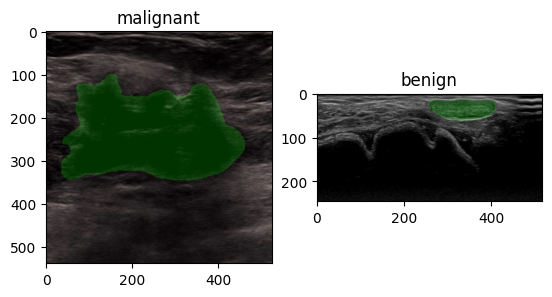

In [6]:
def color_palette():
    """
    output: pixel values for classes in predictions

    Contains values for the unlabeled background,
    and also for the labeled objects.
    """
    return [
        [0, 0, 0],
        [0, 255, 0],
        [255, 0, 0],
    ]


def get_seg_overlay(image, seg):
    """
    input: an image and a mask
    output: the image and the mask combined, colorized by class
    """
    color_seg = np.zeros((seg.shape[0], seg.shape[1], 3), dtype=np.uint8)
    palette = np.array(color_palette())
    for label, color in enumerate(palette):
        color_seg[seg == label, :] = color

    # Show image + mask
    img = np.array(image) * 0.8 + color_seg * 0.2
    img = img.astype(np.uint8)

    return img


test_img_0 = get_seg_overlay(
    test_ds_orig[1]["pixel_values"], np.array(test_ds_orig[1]["label"])
)
test_img_2 = get_seg_overlay(
    test_ds_orig[2]["pixel_values"], np.array(test_ds_orig[2]["label"])
)

f, axs = plt.subplots(1, 2)

axs[0].set_title("malignant", {"fontsize": 12})
axs[0].imshow(test_img_0)
axs[1].set_title("benign", {"fontsize": 12})
axs[1].imshow(test_img_2)


# Augmentations and feature extraction (normalize, resize)

In [7]:
# normalize images for the transformer input
# make sure data formats are right
feature_extractor = SegformerFeatureExtractor(do_normalize=True)

# modeled loosely after the default FastAI augments
training_augments = A.Compose(
    [
        A.RandomBrightnessContrast(brightness_limit=0.5, contrast_limit=0.5, p=0.75),
        A.HorizontalFlip(p=0.5),
        A.Rotate(
            limit=(-30, 30),
            interpolation=cv2.INTER_LINEAR,
            border_mode=cv2.BORDER_REFLECT_101,
            mask_value=0,
            p=0.75,
        ),
        A.Affine(
            scale=(0.833, 1.2),
            translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
            rotate=None,
            shear={"x": (-30, 30), "y": (-30, 30)},
            interpolation=cv2.INTER_LINEAR,
            cval_mask=0,
            p=0.75,
        ),
    ]
)


def train_transforms(example_batch):
    """
    input: a batch of images and masks
    output: augmented and preprocessed images and masks

    This is for training.

    Images get all the augmentations, including pixel-value (brightness, contrast).
    Images also get feature-extracted (normalized).

    Masks only get the geometric transforms (rotation, etc).
    """
    batch_items = list(
        zip(
            [x for x in example_batch["pixel_values"]],
            [x for x in example_batch["label"]],
        )
    )
    batch_items_aug = [
        training_augments(
            image=np.array(x[0]),
            mask=np.array(x[1]),
        )
        for x in batch_items
    ]
    images = [i["image"] for i in batch_items_aug]
    labels = [i["mask"] for i in batch_items_aug]
    inputs = feature_extractor(images, labels)
    return inputs


def val_transforms(example_batch):
    """
    input: a batch of images and masks
    output: augmented and preprocessed images and masks

    This is for validation while training. No augmentations done here.

    Images get normalized.
    """
    images = [x for x in example_batch["pixel_values"]]
    labels = [x for x in example_batch["label"]]
    inputs = feature_extractor(images, labels)
    return inputs


# Set transforms
train_ds.set_transform(train_transforms)
test_ds.set_transform(val_transforms)


# Show samples from the training dataset

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(3, 512, 512) (512, 512)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

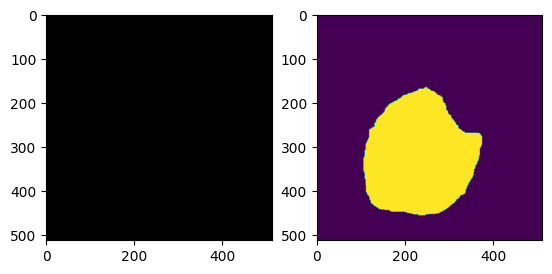

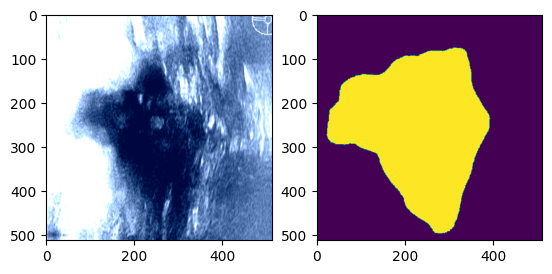

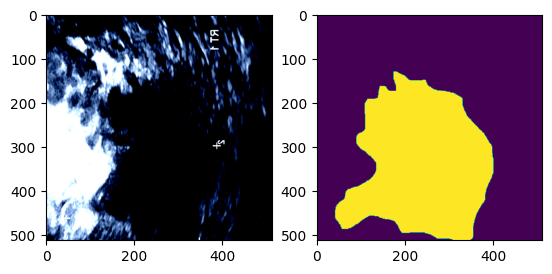

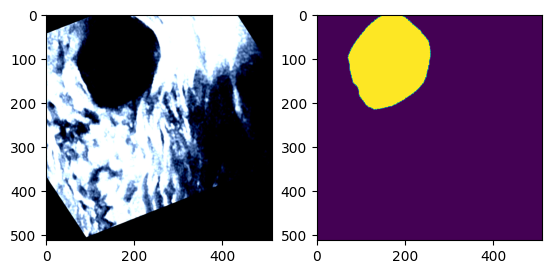

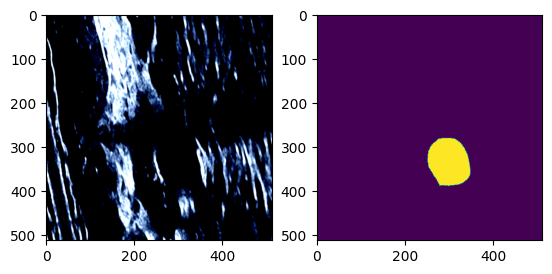

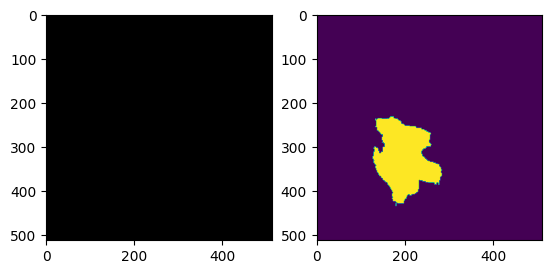

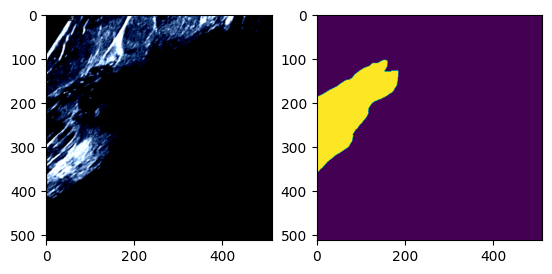

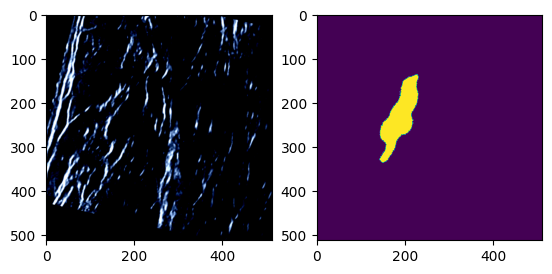

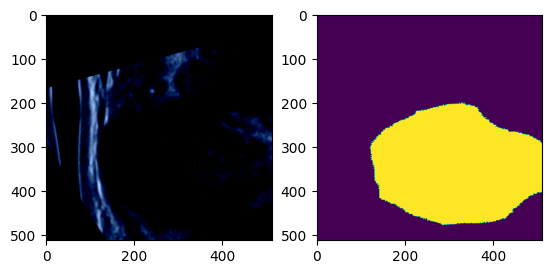

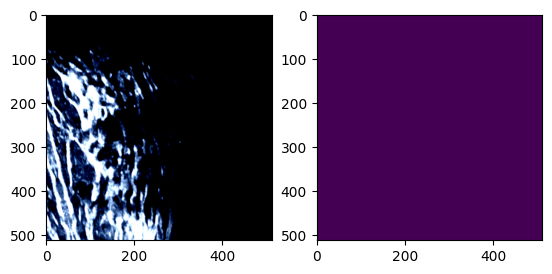

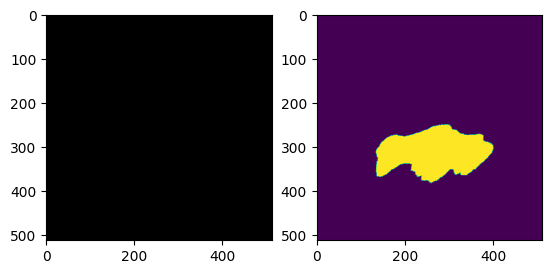

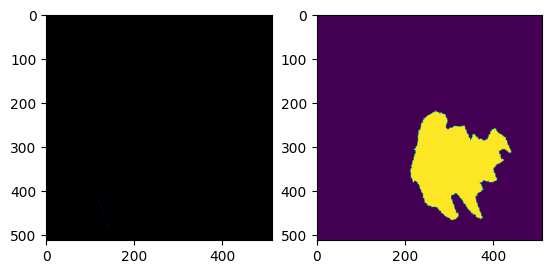

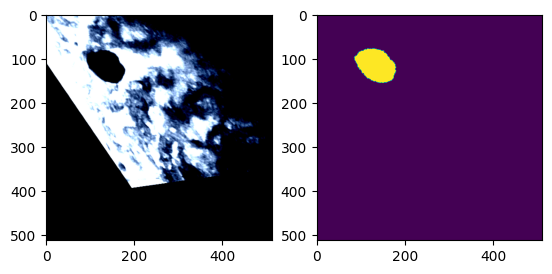

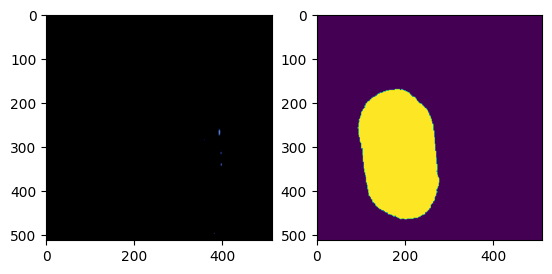

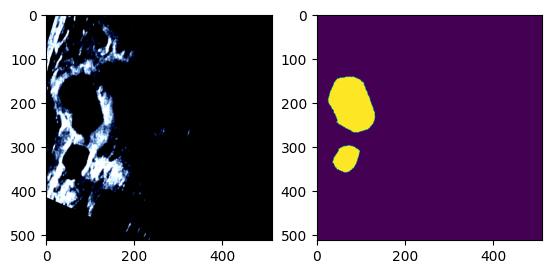

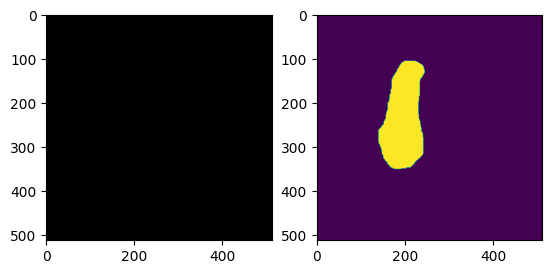

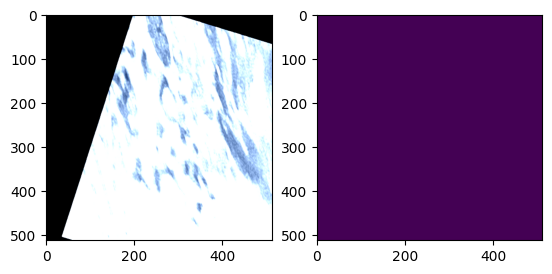

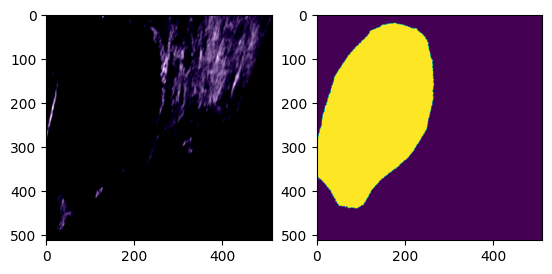

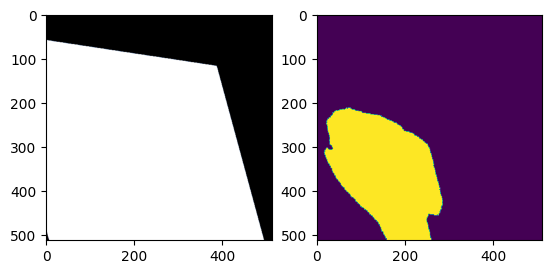

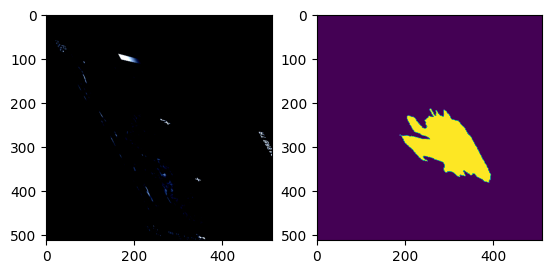

In [8]:
n_img = 20

for i in range(n_img):
    train_item = train_ds[i]
    if i == 0:
        print(train_item["pixel_values"].shape, train_item["labels"].shape)
    fig, ax = plt.subplots(nrows=1, ncols=2)
    ax[0].imshow(train_item["pixel_values"].T)
    ax[1].imshow(train_item["labels"].T)
plt.show()


# Load pretrained model, fine tune it on labeled datasets

In [9]:
metric = evaluate.load(
    # "evaluate/metrics/mean_iou",
    "mean_iou",
    num_process=multiprocessing.cpu_count(),
)


def compute_metrics(eval_pred):
    """
    Compute training / validation metrics.
    This is called by the trainer.
    """
    with torch.no_grad():
        logits, labels = eval_pred
        logits_tensor = torch.from_numpy(logits)

        # scale the logits to the size of the label
        logits_tensor = nn.functional.interpolate(
            logits_tensor,
            size=labels.shape[-2:],
            mode="bilinear",
            align_corners=False,
        ).argmax(dim=1)

        pred_labels = logits_tensor.detach().cpu().numpy()
        metrics = metric._compute(
            predictions=pred_labels,
            references=labels,
            num_labels=len(id2label),
            ignore_index=0,
            reduce_labels=feature_extractor.reduce_labels,
        )

        # BUG: ignore_index=0 doesn't work properly
        # mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
        #
        # IoU for index=0 is always 0, but it's never ignored
        # multiplying by 1.5 to fix it (3 metrics in the average, but the 3rd is always 0)
        mean_iou = metrics["mean_iou"]
        metrics.update({"mean_iou": 2.0 * mean_iou})

        # add per category metrics as individual key-value pairs
        per_category_accuracy = metrics.pop("per_category_accuracy").tolist()
        per_category_iou = metrics.pop("per_category_iou").tolist()

        metrics.update(
            {f"accuracy_{id2label[i]}": v for i, v in enumerate(per_category_accuracy)}
        )
        metrics.update(
            {f"iou_{id2label[i]}": v for i, v in enumerate(per_category_iou)}
        )

        return metrics


In [10]:
# delete/recreate folder with per-trial best and latest models
shutil.rmtree(output_dir, ignore_errors=True)
os.makedirs(output_dir, exist_ok=True)

shutil.rmtree(model_dir, ignore_errors=True)
os.makedirs(model_dir)

shutil.rmtree(logging_dir, ignore_errors=True)
os.makedirs(logging_dir, exist_ok=True)

# fixed hyperparameters
# the model was chosen based on size
pretrained_model_name = "nvidia/mit-b3"
epochs = 20
lr_scheduler_type = "cosine"
batch_size = 8
learning_rate = 8.036476765381927e-5
weight_dec = 1.1897828496112467e-5
warmup_ratio = 0.005257544367948702
trial_number = 0

# avoid printing useless warnings
logging.set_verbosity(50)
# load pretrained transformer from public repos
model = SegformerForSemanticSegmentation.from_pretrained(
    pretrained_model_name,
    id2label=id2label,
    label2id=label2id,
    num_labels=num_labels,
)
# restore normal verbosity
logging.set_verbosity(40)

training_args = TrainingArguments(
    output_dir=output_dir,
    overwrite_output_dir=True,
    learning_rate=learning_rate,
    weight_decay=weight_dec,
    num_train_epochs=epochs,
    lr_scheduler_type=lr_scheduler_type,
    warmup_ratio=warmup_ratio,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    auto_find_batch_size=False,
    save_total_limit=3,
    evaluation_strategy="steps",
    save_strategy="steps",
    save_steps=20,
    eval_steps=20,
    logging_dir=logging_dir + "/trial-" + str(trial_number).zfill(10),
    logging_steps=1,
    log_level="error",
    eval_accumulation_steps=5,
    disable_tqdm=False,
    load_best_model_at_end=False,
    metric_for_best_model="iou_lesion",
    greater_is_better=True,
    optim="adamw_hf",
    push_to_hub=False,
    dataloader_num_workers=multiprocessing.cpu_count(),
    seed=1,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    compute_metrics=compute_metrics,
)

trainer.train()


/home/florin/.local/lib/python3.10/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


/home/florin/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
/home/florin/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
/home/florin/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
/home/florin/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeW

TrainOutput(global_step=3600, training_loss=0.07027537192955302, metrics={'train_runtime': 3880.3547, 'train_samples_per_second': 7.396, 'train_steps_per_second': 0.928, 'total_flos': 6.395243903896781e+18, 'train_loss': 0.07027537192955302, 'epoch': 20.0})

# Save best model and reload

In [11]:
model.save_pretrained(model_dir)


In [ ]:
try:
    del model
except Exception as e:
    pass
torch.cuda.empty_cache()

model = SegformerForSemanticSegmentation.from_pretrained(
    model_dir, id2label=id2label, label2id=label2id, num_labels=num_labels
)
model.to("cuda:0")


# Sample predictions on the validation dataset

  0%|          | 0/40 [00:00<?, ?it/s]

/tmp/ipykernel_796482/2522394822.py:26: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  f, axs = plt.subplots(1, 2)


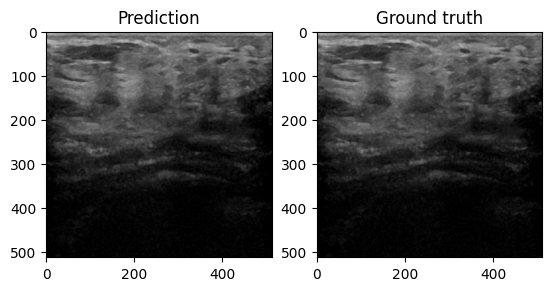

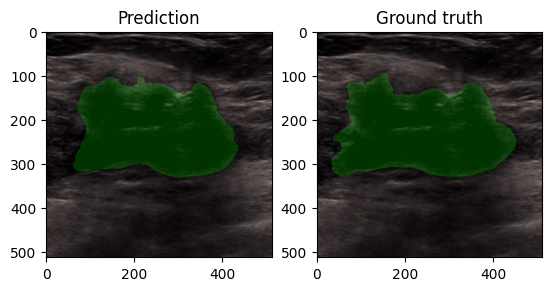

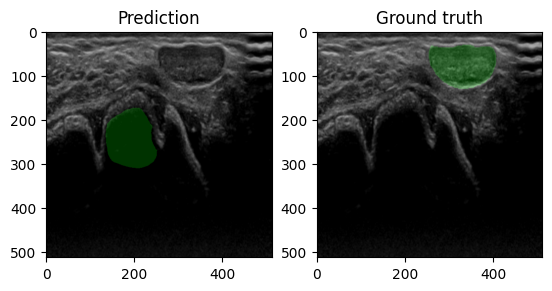

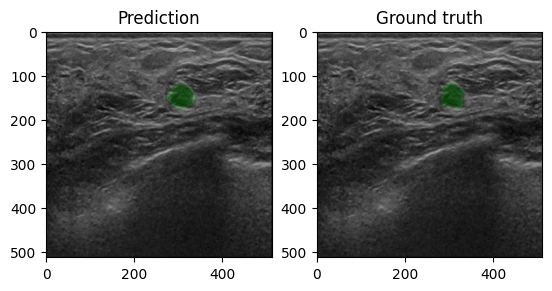

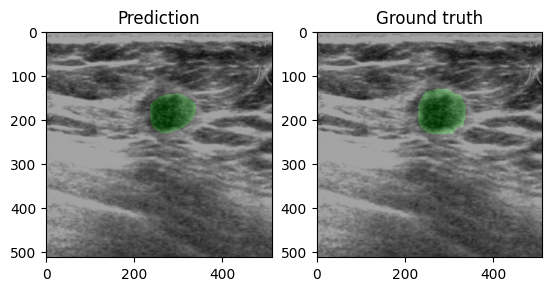

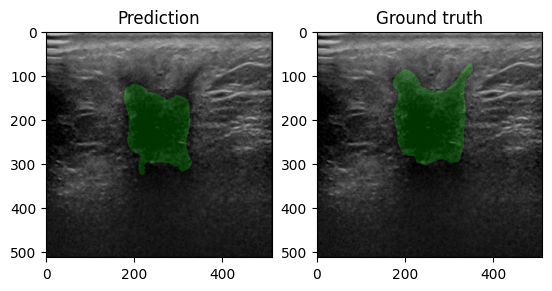

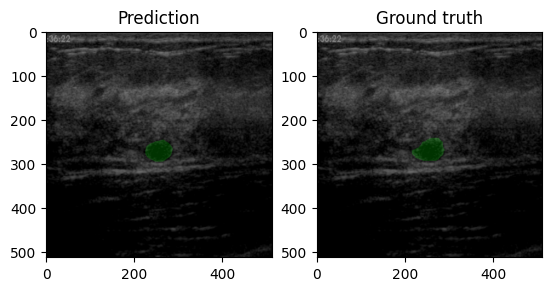

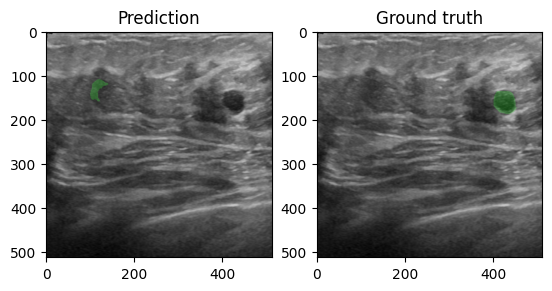

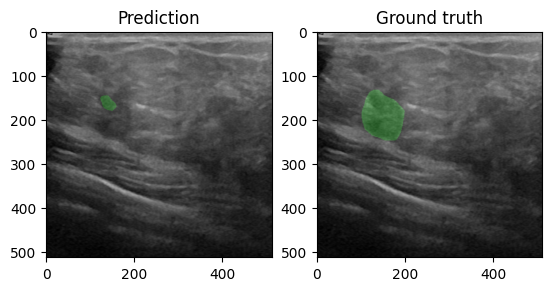

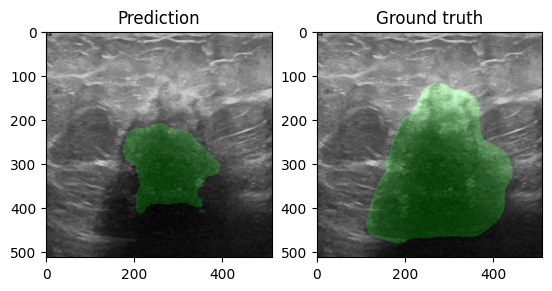

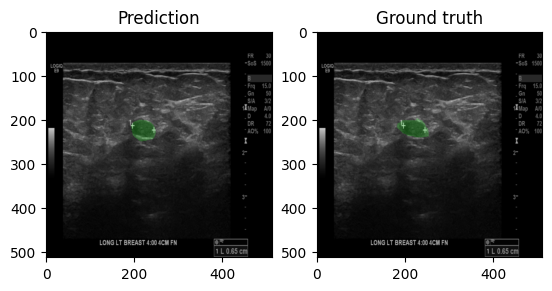

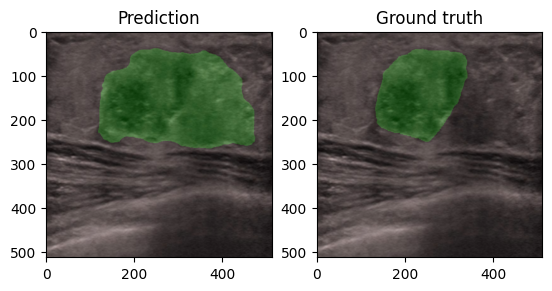

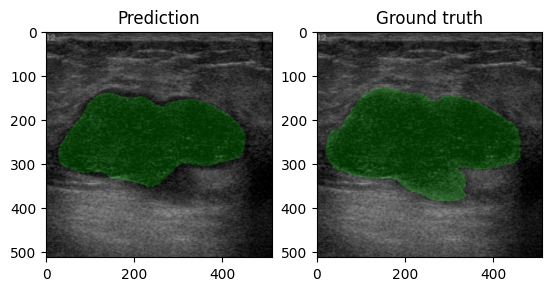

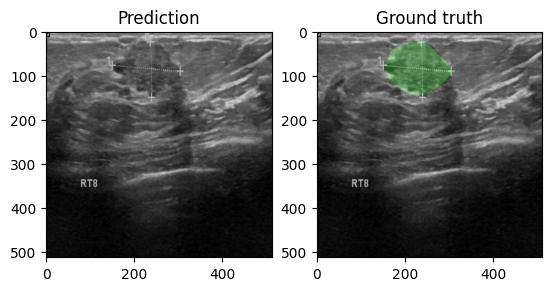

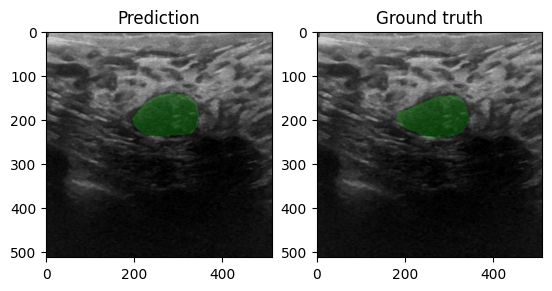

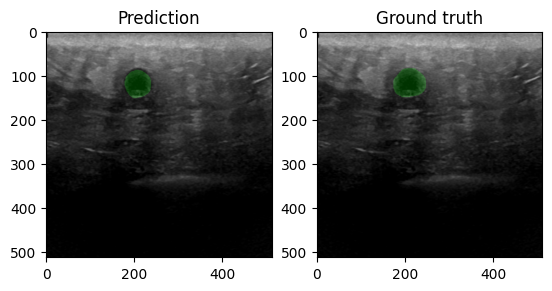

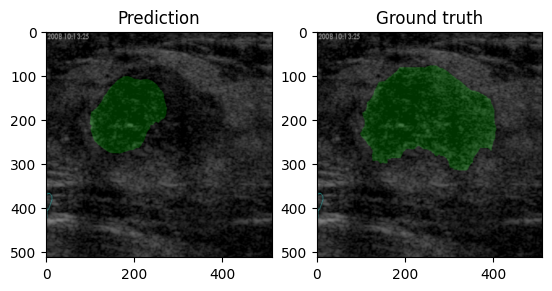

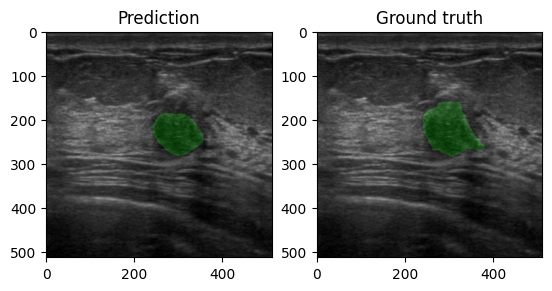

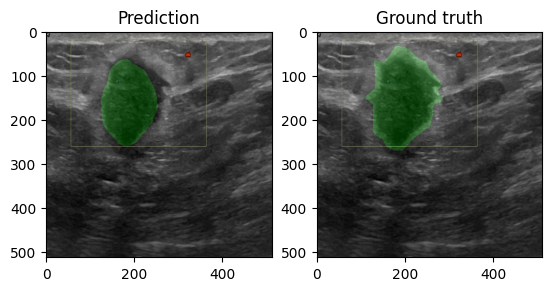

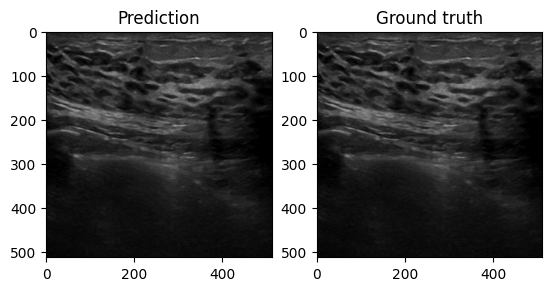

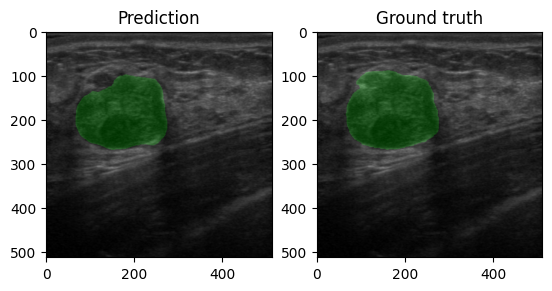

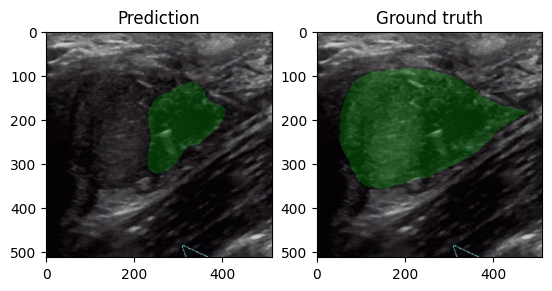

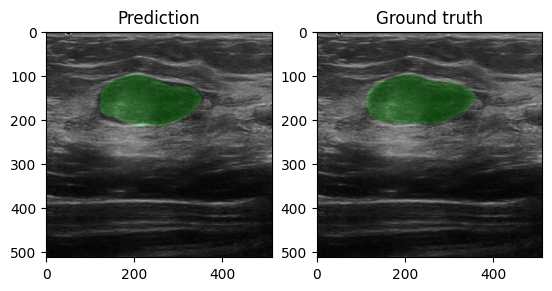

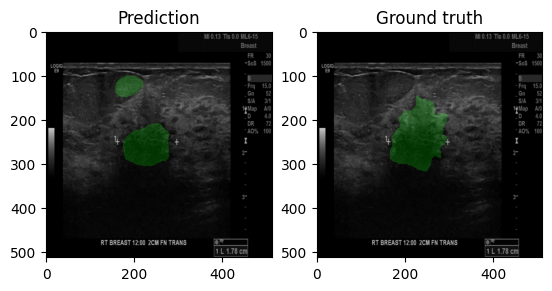

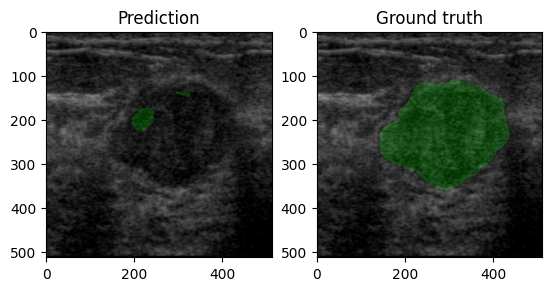

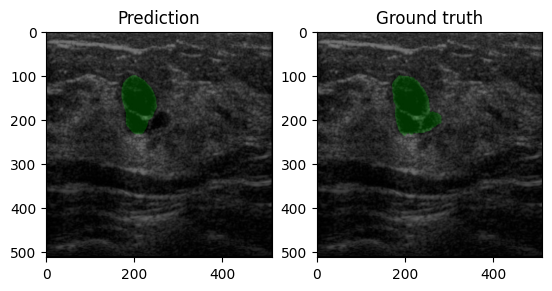

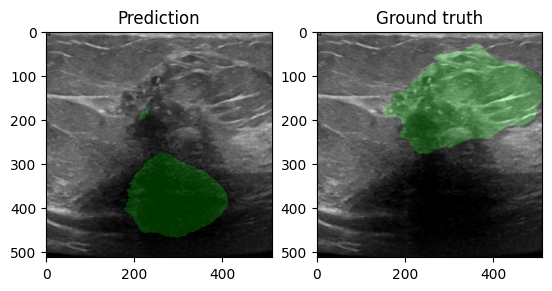

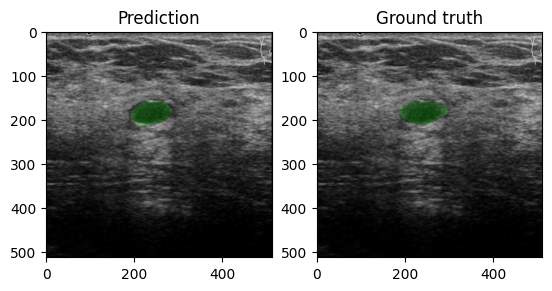

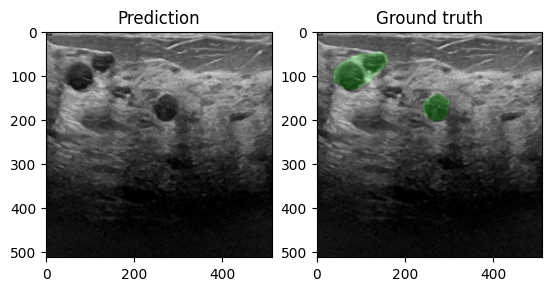

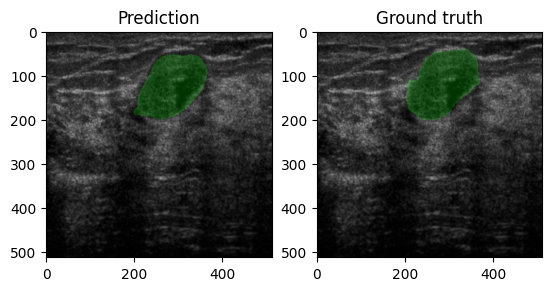

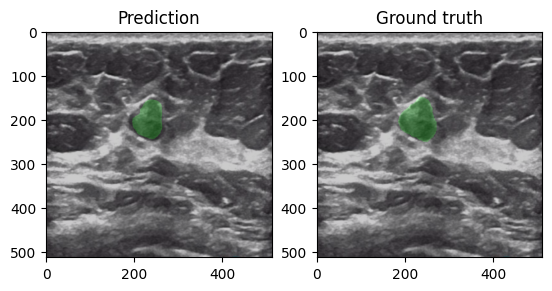

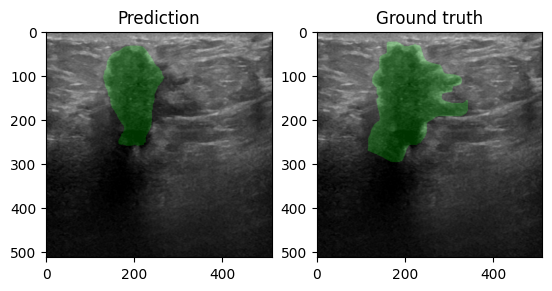

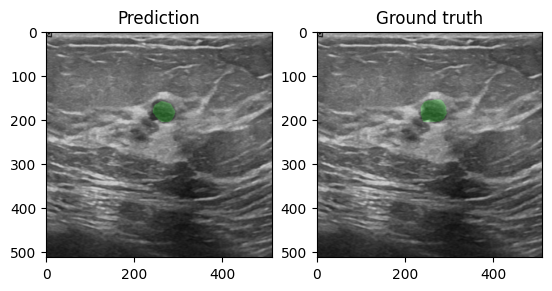

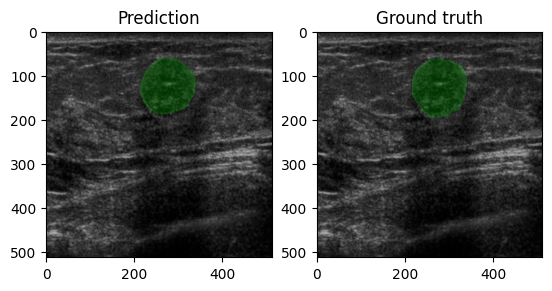

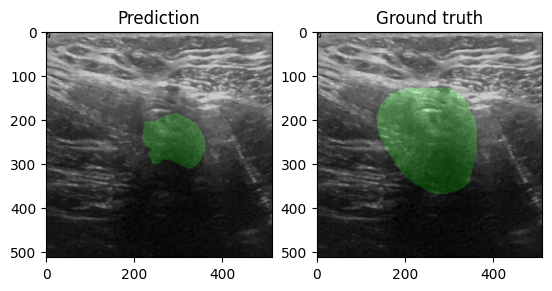

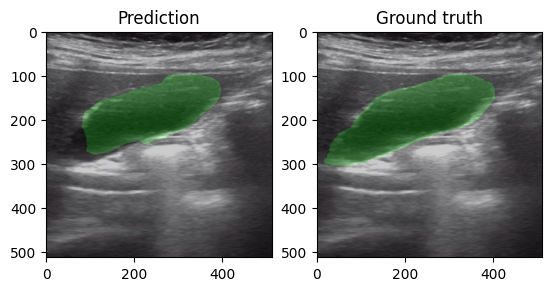

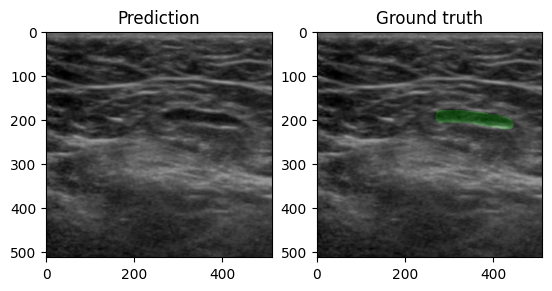

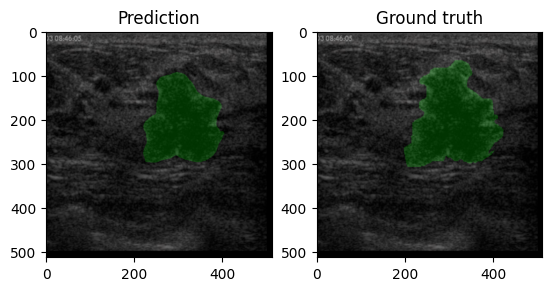

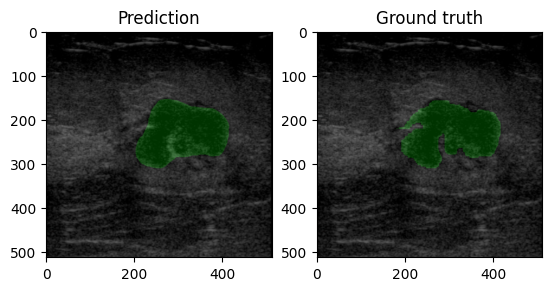

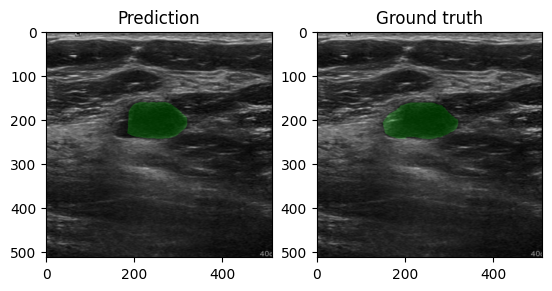

In [13]:
for i_ind in tqdm(range(0, 40)):
    image = test_ds[i_ind]["pixel_values"]
    gt_seg = test_ds[i_ind]["labels"]

    inputs = feature_extractor(images=image, return_tensors="pt")
    inputs.to("cuda:0")
    outputs = model(**inputs)
    logits = outputs.logits

    # First, rescale logits to original image size
    upsampled_logits = nn.functional.interpolate(
        logits,
        size=image.shape[1:],  # (height, width)
        mode="bilinear",
        align_corners=False,
    )

    # Second, apply argmax on the class dimension
    pred_seg = upsampled_logits.argmax(dim=1)[0]

    image_orig = test_ds_orig[i_ind]["pixel_values"]
    image_orig = image_orig.resize((512, 512), resample=PIL.Image.Resampling.BILINEAR)

    pred_img = get_seg_overlay(image_orig, pred_seg.cpu())
    gt_img = get_seg_overlay(image_orig, np.array(gt_seg))
    f, axs = plt.subplots(1, 2)

    axs[0].set_title("Prediction", {"fontsize": 12})
    axs[0].imshow(pred_img)
    axs[1].set_title("Ground truth", {"fontsize": 12})
    axs[1].imshow(gt_img)


# Load video dataset

In [14]:
buv_df = buv_dataset_make(data_volume)
# convert Path to string because HuggingFace needs the string type
buv_df["image"] = buv_df["image"].apply(lambda x: str(x))
buv_df


dataset      class             video  \
0      BUV_dataset     benign  263b86b85a58f270   
1      BUV_dataset     benign  263b86b85a58f270   
2      BUV_dataset     benign  263b86b85a58f270   
3      BUV_dataset     benign  263b86b85a58f270   
4      BUV_dataset     benign  263b86b85a58f270   
...            ...        ...               ...   
25267  BUV_dataset  malignant  xf7f83b2a576016b   
25268  BUV_dataset  malignant  xf7f83b2a576016b   
25269  BUV_dataset  malignant  xf7f83b2a576016b   
25270  BUV_dataset  malignant  xf7f83b2a576016b   
25271  BUV_dataset  malignant  xf7f83b2a576016b   

                                                                                                         image  \
0         /home/florin/data/BUS Project Home/Datasets/BUV_dataset/rawframes/benign/263b86b85a58f270/000000.png   
1         /home/florin/data/BUS Project Home/Datasets/BUV_dataset/rawframes/benign/263b86b85a58f270/000001.png   
2         /home/florin/data/BUS Project Home/Datasets/BUV_dataset/rawframes/benign/263b86b85a58f270/000002.png   
3         /home/florin/data/BUS Project Home/Datasets/BUV_dataset/rawframes/benign/263b86b85a58f270/000003.png   
4         /home/florin/data/BUS Project Home/Datasets/BUV_dataset/rawframes/benign/263b86b85a58f270/000004.png   
...                                                                                                        ...   
25267  /home/florin/data/BUS Project Home/Datasets/BUV_dataset/rawframes/malignant/xf7f83b2a576016b/000186.png   
25268  /home/florin/data/BUS Project Home/Datasets/BUV_dataset/rawframes/malignant/xf7f83b2a576016b/000187.png   
25269  /home/florin/data/BUS Project Home/Datasets/BUV_dataset/rawframes/malignant/xf7f83b2a576016b/000188.png   
25270  /home/florin/data/BUS Project Home/Datasets/BUV_dataset/rawframes/malignant/xf7f83b2a576016b/000189.png   
25271  /home/florin/data/BUS Project Home/Datasets/BUV_dataset/rawframes/malignant/xf7f83b2a576016b/000190.png   

      str_index  
0         00000  
1         00001  
2         00002  
3         00003  
4         00004  
...         ...  
25267     25267  
25268     25268  
25269     25269  
25270     25270  
25271     25271  

[25272 rows x 5 columns]

In [15]:
def map_hf_video_ds(row):
    ret = {}
    ret["dataset"] = row["dataset"]
    ret["class"] = row["class"]
    ret["video"] = row["video"]
    ret["str_index"] = row["str_index"]
    # ret["pixel_values"] = [Image.open(pv).convert("RGB") for pv in row["pixel_values"]]
    ret["pixel_values"] = Image.open(row["pixel_values"]).convert("RGB")
    return ret


def create_hf_video_dataset(df):
    dataset = Dataset.from_dict(
        {
            "dataset": df["dataset"].to_list(),
            "class": df["class"].to_list(),
            "video": df["video"].to_list(),
            "pixel_values": df["image"].to_list(),
            "str_index": df["str_index"].to_list(),
        }
    )
    dataset = dataset.map(
        map_hf_video_ds,
        num_proc=multiprocessing.cpu_count(),
        writer_batch_size=multiprocessing.cpu_count() ** 2,
    )
    dataset = dataset.cast_column(
        "dataset", ClassLabel(names=df["dataset"].unique().tolist())
    )
    dataset = dataset.cast_column(
        "class", ClassLabel(names=df["class"].unique().tolist())
    )
    dataset = dataset.cast_column(
        "video", ClassLabel(names=df["video"].unique().tolist())
    )
    dataset = dataset.cast_column("pixel_values", ImageDS())
    return dataset


if os.path.isdir(video_dataset_path):
    ds_hf_video = load_from_disk(video_dataset_path)
else:
    ds_hf_video = create_hf_video_dataset(buv_df)
    ds_hf_video.save_to_disk(video_dataset_path)

feature_extractor = SegformerFeatureExtractor()


def video_transforms(example_batch):
    images = [x for x in example_batch["pixel_values"]]
    inputs = feature_extractor(images)
    return inputs


# Not needed, feature_extractor() is applied below in the loop.
# ds_hf_video.set_transform(video_transforms)


In [16]:
ds_hf_video[0]


{'dataset': 0,
 'class': 0,
 'video': 0,
 'pixel_values': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=522x522>,
 'str_index': '00000'}

# Generate mask predictions for video

In [ ]:
"""
video_dataloader = DataLoader(
    ds_hf_video,
    batch_size=multiprocessing.cpu_count(),
    num_workers=multiprocessing.cpu_count(),
)

from transformers import BatchFeature
"""

palette = np.array(color_palette())
index_len = len(str(len(ds_hf_video)))

outdir_base = "frames"
outdir = outdir_base + "/masks_segformer_single_class"
shutil.rmtree(outdir, ignore_errors=True)
os.makedirs(outdir, exist_ok=True)

for i, frame in tqdm(enumerate(ds_hf_video), total=len(ds_hf_video)):
    inputs = feature_extractor(images=frame["pixel_values"], return_tensors="pt").to(
        "cuda:0"
    )
    outputs = model(**inputs)
    logits = outputs.logits.cpu()
    ups_logits = nn.functional.interpolate(
        logits,
        size=(512, 512),
        mode="bilinear",
        align_corners=False,
    )
    predicted_segments = ups_logits.argmax(dim=1)[0]
    mask = Image.fromarray(predicted_segments.numpy().astype(np.uint8), mode="L")
    image_index_str = str(i).rjust(index_len, "0")
    mask.save(outdir + "/f" + image_index_str + ".png", format="png")

    # color_seg = np.zeros((predicted_segments.shape[0], predicted_segments.shape[1], 3), dtype=np.uint8)
    # for label, color in enumerate(palette):
    # color_seg[predicted_segments == label, :] = color


# Render a few samples from the video dataset

In [ ]:
feature_extractor = SegformerFeatureExtractor()

bdl = buv_df.shape[0]
# for i_ind in tqdm(range(buv_df.shape[0])):
for i_ind in tqdm(list(range(5)) + list(range(bdl - 5, bdl))):
    df_row = buv_df.loc[i_ind]
    image = Image.open(df_row["image"])
    image_resize = image.resize((128, 128), resample=PIL.Image.Resampling.BILINEAR)

    inputs = feature_extractor(images=image, return_tensors="pt")
    inputs.to("cuda:0")
    outputs = model(**inputs)
    logits = outputs.logits

    # First, rescale logits to original image size
    upsampled_logits = nn.functional.interpolate(
        logits,
        size=image_resize.shape,  # (height, width)
        mode="bilinear",
        align_corners=False,
    )

    # Second, apply argmax on the class dimension
    pred_seg = upsampled_logits.argmax(dim=1)[0]

    pred_img = get_seg_overlay(image_resize, pred_seg.cpu())

    f, axs = plt.subplots(1, 2)

    axs[0].set_title("Prediction", {"fontsize": 12})
    axs[0].imshow(pred_img)
    axs[1].set_title("Original Image", {"fontsize": 12})
    axs[1].imshow(image_resize)


https://huggingface.co/docs/datasets/use_with_pytorch